### 데이터 수집하기

NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
<br/>
조사 접미사와 같은 문장에 자주 등장하지만 의미를 분석하고 요약하는데 거의 의미가 없는 100여개의 불용어는 정리되어 있음

In [1]:
#NLTK 패키지에서 불용어 사전 다운로드
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tqdm import tqdm # 진행되는 %를 시각적으로 확인하고자 할때 사용
import time

In [3]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
79363,Maha issues draft rules to regularise illegal ...,The Maharashtra government on Friday issued dr...
79892,Jagga Jasoos actress Bidisha found dead in her...,"Actress and singer Bidisha Bezbaruah, who was ..."
89620,Israel mulls kicking out UN from Jerusalem,Israeli minister Miri Regev has asked the gove...
71161,"Nadal powers into his 23rd Grand Slam final, 4...",World number one tennis player Rafael Nadal re...
28088,Bank of Maharashtra CEO Ravindra Marathe loses...,The Bank of Maharashtra board on Friday stripp...
9772,There was too much pressure on Unadkat over hi...,IPL franchise Rajasthan Royals have said they ...
47593,"Jennifer Aniston, Justin Theroux announce thei...",Jennifer Aniston and Justin Theroux have issue...
53455,CSK rope in former player Michael Hussey as ba...,Two-time IPL champions Chennai Super Kings hav...
46409,CCTV footage at Kejriwal's house running 40 mi...,After Delhi Police seized CCTV recordings from...
87471,"Germans are very bad, will end German car sale...",US President Donald Trump has threatened to st...


### 데이터 전처리하기

#### 중복제거 및 NULL 값 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


#### 1. 중복 제거하기
inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### NULL 값 유무 확인하기
duplicates로 중복을 제거하면서 NULL값도 제거가 되지만 그래도 NULL 값이 남아있을 수 있음
<br/>
duplicate는 기능은 중복을 제거하는 것이기 때문!!

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


isnull() 활용하여 NULL 값 확인 결과 headline , text 모두 0 이 나옴 <br/>
즉, headlines과 text 데이터에는 NULL 값이 없다는 의미!!
<br/>
만약 isnull()로 확인 후 0이 아닌 값이 나오면 NULL이 해당 숫자만큼 존재한다는 의미이기 때문에 dropna()을 활용하여 제거해야함

### 덱스트 정규화와 불용어 제거

학습에 불필요한 표현을 제거하기 위한 단계(축약적인 의미 단어를 제거)
<br/>
텍스트 정규화(text normalization)를 위한 사전(dictionary)구성

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
#정규화 사전의 수:  120

정규화 사전의 수:  120


#### 불용어 제거

자연어 처리 시 실질적으로 도움되지 않는 단어 제거<br/>
얼마나 많은 불용어를 제거함에 따라 성능을 높일 수 있음

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))


불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

추상적요약을 사용시에는 문장 길이가 짧은 summary 전처리할 때는 불용어 제거하지 않음
<br/>
추상적 요약에서는 자연스러운 문장이 되려면 불용어가 남아 있는게 더 좋음

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [08:50<00:00, 185.46it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []

for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98360/98360 [00:17<00:00, 5496.35it/s]

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
len(clean_headlines)

98360

#### 데이터 정제 후 NULL 확인

텍스트 정제 과정에서 NULL이 발생할 수 있기 때문에 NULL 확인 하는 것이 좋음

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
len(data)

98360

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


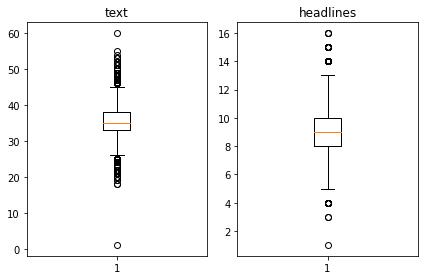

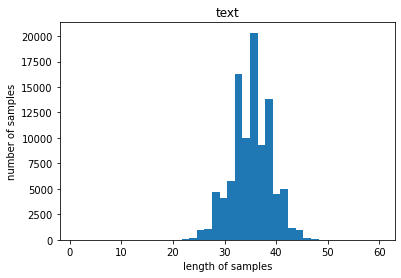

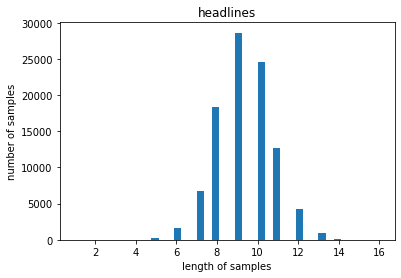

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

많은 양의 데이터를 다룰 때 데이터를 시각화하여 보는 것에 도움됨
<br/>
각 테스트와 제목의 길이 분포와 길이별 개수를 시각적으로 보여줌

In [18]:
text_max_len = 40
headline_max_len = 11
#얼마만큼 많은 샘플을 잘르지 안ㄶ고 포함하는지 통계로 확인하여 객관적으로 길이 지정

#### train, test 데이터 몇 %해당되는지 확인

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


전체 샘플에 약 8%의 샘플들잉 내용이 망가짐

#### 정해진 길이보다 길면 제외하기

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


#### 시작토큰과 종료 토큰 추가하기

seq2seq훈련을 하기 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있음
<br/>
시작토큰 sostoken, 종료토큰 eostoken
<br/>
시작토큰 맨 앞 문장 decoder_input, 종료토큰 맨 뒤에 붙는 문장 decoder_target이라고 정함

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


인코더 입력, 디코더 입력과 레이블을 각 numpy타입으로 저장
<br/>
encoder_input과 크기와  형태가 같은 순서가 섞인 정수 시퀀스를 만듦

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[79029 30572 63344 ... 55000 11456 59026]


정수 시퀀스를 이용 데이터 샘플 순서 정의

In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


데이터를 8:2비율로 훈련 데이터와 테스트 데이터 분리
<br/>
전체 데이터의 크기에 0.2를 곱해 테스트 데이터 크기 정의

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 정수 인코딩하기

각 단어에 고유한 정수를 맴핑하기 위해 단어집합(vocabulary)을 만듦

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

keras의 토큰나이저 사용하여 훈련 데이터로부터 단어 집합을 만듦
<br/>
현재 생성된 단어 집합은 src_tokenizer.word_index에 저장됨
<br/>
빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행함

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64731
등장 빈도가 6번 이하인 희귀 단어의 수: 44173
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20558
단어 집합에서 희귀 단어의 비율: 68.24087376990931
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.781309237110342


등장빈도수 7회 비만인 단어 확인
<br/>
src_tokenzier.word_counts.items()에 단어와 각 단어의 등장 빈도수 저장되어 있기 때문에 사용하여 확인 가능


In [30]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[569, 6227, 133, 828, 613, 2312, 5056, 6227, 5535, 416, 176, 5462, 942, 1371, 133, 4197, 6, 3308, 2685, 3022, 273, 89, 294, 164, 2809], [3936, 479, 49, 421, 81, 89, 3, 485, 1653, 5707, 71, 30, 451, 873, 4633, 2754, 49, 1, 2628, 1055, 5283, 892, 3061, 456, 806, 421, 81, 1003, 3, 220, 667, 107, 1738, 351, 108, 2754, 395], [278, 1424, 985, 598, 264, 7209, 2088, 12, 2182, 862, 4273, 4198, 980, 494, 3345, 4389, 20, 109, 221, 58, 4198, 985, 1925, 5396, 2007, 4872, 4, 60, 4563, 7917, 211, 12, 2182, 2, 5, 722]]


In [32]:
#headline에도 동일하게 적용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

단어집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨
<br/>
tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장됨

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28502
등장 빈도가 5번 이하인 희귀 단어의 수: 18756
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9746
단어 집합에서 희귀 단어의 비율: 65.80590835730827
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.162925801824562


In [34]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 180, 9, 1195, 4, 7, 378, 5, 28], [1, 197, 843, 50, 63, 1131], [1, 252, 1045, 1333, 499, 173, 4, 27], [1, 757, 985, 3, 184, 4, 390, 648, 55], [1, 84, 12, 84, 5, 6]]
target
decoder  [[180, 9, 1195, 4, 7, 378, 5, 28, 2], [197, 843, 50, 63, 1131, 2], [252, 1045, 1333, 499, 173, 4, 27, 2], [757, 985, 3, 184, 4, 390, 648, 55, 2], [84, 12, 84, 5, 6, 2]]


빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되어 있던 샘플은 empty 되었을 가능성이 있음

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 68665
훈련 레이블의 개수 : 68665
테스트 데이터의 개수 : 17166
테스트 레이블의 개수 : 17166


길이가 0이된 headline은 실제로는 길이가 1
<br/>
sotoken, eostoken만 남아 있기 때문
<br/>
훈련데이터와 테스트 데이터에 대해 headline 길이가 1인 경우 인덱스를 각 drop_train, drop_test로 저장

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68665
훈련 레이블의 개수 : 68665
테스트 데이터의 개수 : 17166
테스트 레이블의 개수 : 17166


### 패딩하기

서로 다른 길이의 샘플을 병렬 처리하기 위해 같은 길이로 맞춰주는 작업이 필요함
<br/>
최대 길이보다 짧은 데이터들은 뒤에 숫자 0을 넣어 최대 길이로 맞춤

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')


### 모델 설계하기

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터 차원 128로 정의. hidden state의 크기를 256로 정의
<br/>
hidden state는 LSTM에서 얼만큼 수용력을 가질지를 정하는 파리미터
<br/>
인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코딩과 거의 동일함
<br/>
LSTM의 입력을 정의할 때 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야함

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

수행하는 어텐션함수를 설계하는 것은 다른 새로운 신경망을 설계해야 한다는 것
<br/>
tensorflow에 구현된 어텐션 함수 사용, Bahadnu 스타일 어텐션 사용

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

인코더의 hidden state들과 디코더 hidden state들을 어텐션 함수 입력을 사용, 어텐션 함수가 리턴한 값을 예측 시 디코더의 hidden state와 함께 활용하는 형태로 작동된다

### 모델 훈련하기

조기 종료를 뜻하는 EarlyStopping의 특정 조건을 충족되면 훈련을 멈춤
<br/>
val_loss을 관찰하다가 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2)관측되면 학습을 멈추도록 설정함
<br/>
EarlyStopping이 작동하면 epoch이 크게 설정되도 모델 훈련이 최적점에 멈출 수 있음

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

Epoch 1/50
269/269 [==============================] - 178s 599ms/step - loss: 4.1827 - val_loss: 3.8940
Epoch 2/50
269/269 [==============================] - 160s 596ms/step - loss: 3.7170 - val_loss: 3.5583
Epoch 3/50
269/269 [==============================] - 160s 594ms/step - loss: 3.4263 - val_loss: 3.3527
Epoch 4/50
269/269 [==============================] - 159s 592ms/step - loss: 3.2289 - val_loss: 3.2059
Epoch 5/50
269/269 [==============================] - 160s 594ms/step - loss: 3.0760 - val_loss: 3.0931
Epoch 6/50
269/269 [==============================] - 160s 594ms/step - loss: 2.9549 - val_loss: 2.9977
Epoch 7/50
269/269 [==============================] - 160s 593ms/step - loss: 2.8534 - val_loss: 2.9376
Epoch 8/50
269/269 [==============================] - 160s 594ms/step - loss: 2.7645 - val_loss: 2.8663
Epoch 9/50
269/269 [==============================] - 159s 592ms/step - loss: 2.6853 - val_loss: 2.8206
Epoch 10/50
269/269 [==============================] - 159s 590m

#### 데이터 손실과 검증 데이터 손실 확인

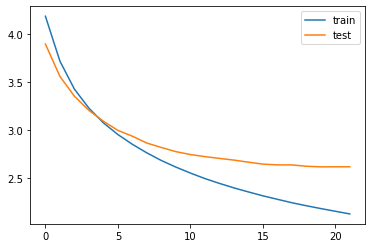

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

위의 그래프의 val_loss와 loss는 EarlyStopping에 설정한 loss값이 epoch이 2번 지났지만 val_loss값이 떨어지지 않기 때문에 학습이 종료됨을 볼 수 있다.
<br/>
loss의 값은 학습이 진행될수록 점차 떨어지는 것을 확인할 수 있지만 val_loss의 경우 epoch=20 이후로는 점차 val_loss의 값이 떨어지지 않고 올라가고 있다.
<br/>
즉, val_loss 값이 올라간다는 것은 train data에만 학습이 이루어지고 있어 test data에 대한 정확도가 떨어진다는 것을 뜻하는 것으로 일반화가 되지 않다는 것을 말하므로 학습이 종료됐다.
<br/>

### 인퍼런스 모델 구현하기

테스트 단계에서 정수 인덱스 행렬 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로 필요한 3개의 사전 준비

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


#### 인코더 모델과 디코더 모델 분리하여 설계

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

=3


In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


### 모델 테스트 하기

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : truck driver madhya pradesh drove burning petrol away petrol pump sunday attempt save lives petrol caught fire petrol pump fire later fire department driver sustained burn injuries admitted hospital 
실제 요약 : man truck away from petrol to save lives 
예측 요약 :  truck carrying into petrol truck in mp


원문 : aiadmk leader ttv dhinakaran friday claimed could get ruling aiadmk government tamil nadu wanted said several mlas asked government people opposing late chief minister jayalalithaa soon removed power dhinakaran rk nagar bypolls last year 
실제 요약 : can tn govt if want aiadmk leader 
예측 요약 :  aiadmk to aiadmk aiadmk


원문 : islamic university uttar pradesh district issued fatwa muslim women cutting hair terming act un islamic officials university department issues said muslim women stay away beauty make attract men 
실제 요약 : islamic issues against women 
예측 요약 :  islamic state students in anti muslim


원문 : technology giant apple retail chief angela said apple users iphone pointing ipho

### 추출적 요약하기

#### 추출젹 요약 사용하기 위해 패키지 import

In [93]:
import requests
from summa.summarizer import summarize

In [107]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(type(text))
print(text[:1500])

<class 'str'>
The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the d

#### Summarize 사용

In [109]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
new_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [111]:
new_data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [114]:
new_text = np.array(new_data['text'])
new_label = np.array(new_data['headlines'])
print(type(new_text[0]))
print(new_text[0])

<class 'str'>
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [129]:
print('예측 headline:')
print(summarize(new_text[0],ratio=0.005,words=10))
print('실제 headline:')
print(new_label[0])

예측 headline:
upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 headline:
upGrad learner switches to career in ML & Al with 90% salary hike


In [128]:
print('예측 headline:')
print(summarize(new_text[2],words=10))
print('실제 headline:')
print(new_label[2])

예측 headline:
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
실제 headline:
New Zealand end Rohit Sharma-led India's 12-match winning streak


### Extractive 요약, Abstractive 요약 비교

추상적 요약과 추출적 요약을 확인해보면 추상적 요약의 경우뉴스 기사 내용에 없는 단어가 조합되어 뉴스 제목으로 결과가 나온 것을 볼 수 있다 <br/>
추출적 요약 결과의 경우 뉴스 기사 내용에 있는 단어를 위주로 요약하여 뉴스 제목으로 결과값이 나왔다.
<br/>
하지만 추상적 요약은 문법적으로 보면 표현이 맞지 않아 무슨 내용을 뜻하는지 한번에 확인하기 어려우며 핵심 단어가 포함되지 않는 경우도 있어 뉴스 기사 제목만 봐도 어떤 뉴스인지 확인하기 어렵다.
<br/>
추출적 요약의 경우 추상적 요약에 비해 문법적 부분과 핵심 단어가 포함되어 있어 뉴스 기사 제목만 보아도 뉴스 기사 내용이 어떤 내용인지 확인할 수 있다.

<br/>